# Problem Statement

You are hired by a tour and travel agency which deals in selling holiday packages. You are provided details of 872 employees of a company. Among these employees, some opted for the package and some didn't. You have to help the company in predicting whether an employee will opt for the package or not on the basis of the information given in the data set. Also, find out the important factors on the basis of which the company will focus on particular employees to sell their packages.

In [83]:
 import numpy as np
import pandas as pd
import matplotlib.pyplot as plt   
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import metrics
from sklearn.metrics import roc_auc_score,roc_curve,classification_report,confusion_matrix

In [84]:
holiday=pd.read_csv("Holiday_Package.csv")

### EDA

In [85]:
holiday.head()

,Unnamed: 0,Holliday_Package,Salary,age,educ,no_young_children,no_older_children,foreign
0,1,no,48412,30,8,1,1,no
1,2,yes,37207,45,8,0,1,no
2,3,no,58022,46,9,0,0,no
3,4,no,66503,31,11,2,0,no
4,5,no,66734,44,12,0,2,no


In [86]:
holiday.isna().sum()

Unnamed: 0           0
Holliday_Package     0
Salary               0
age                  0
educ                 0
no_young_children    0
no_older_children    0
foreign              0
dtype: int64

In [87]:
holiday.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 872 entries, 0 to 871
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         872 non-null    int64 
 1   Holliday_Package   872 non-null    object
 2   Salary             872 non-null    int64 
 3   age                872 non-null    int64 
 4   educ               872 non-null    int64 
 5   no_young_children  872 non-null    int64 
 6   no_older_children  872 non-null    int64 
 7   foreign            872 non-null    object
dtypes: int64(6), object(2)
memory usage: 54.6+ KB


There are no missing values. 6 variables are numeric and remaining categorical. Categorical variables are not in encoded format

### Check for duplicate data

In [88]:
dups = holiday.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))
print(holiday.shape)

Number of duplicate rows = 0
(872, 8)


### Geting unique counts of all Objects

In [89]:
holiday.Holliday_Package.value_counts(normalize=True)

no     0.540138
yes    0.459862
Name: Holliday_Package, dtype: float64

In [90]:
for feature in holiday.columns: 
    if holiday[feature].dtype == 'object': 
        print(feature)
        print(holiday[feature].value_counts())
        print('\n')
        

Holliday_Package
no     471
yes    401
Name: Holliday_Package, dtype: int64


foreign
no     656
yes    216
Name: foreign, dtype: int64




In [91]:
holiday.drop(columns='Unnamed: 0',axis=1,inplace=True)

workclass, occupation,native-country has ?  
Since, high number of cases have ?, we will convert them into a new level

In [92]:
holiday.describe(include='all').transpose() 

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Holliday_Package,872,2,no,471,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Salary,872,NaN,NaN,NaN,47729.2,23418.7,1322,35324,41903.5,53469.5,236961
age,872,NaN,NaN,NaN,39.9553,10.5517,20,32,39,48,62
educ,872,NaN,NaN,NaN,9.30734,3.03626,1,8,9,12,21
no_young_children,872,NaN,NaN,NaN,0.311927,0.61287,0,0,0,0,3
no_older_children,872,NaN,NaN,NaN,0.982798,1.08679,0,0,1,2,6
foreign,872,2,no,656,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Checking for Outliers

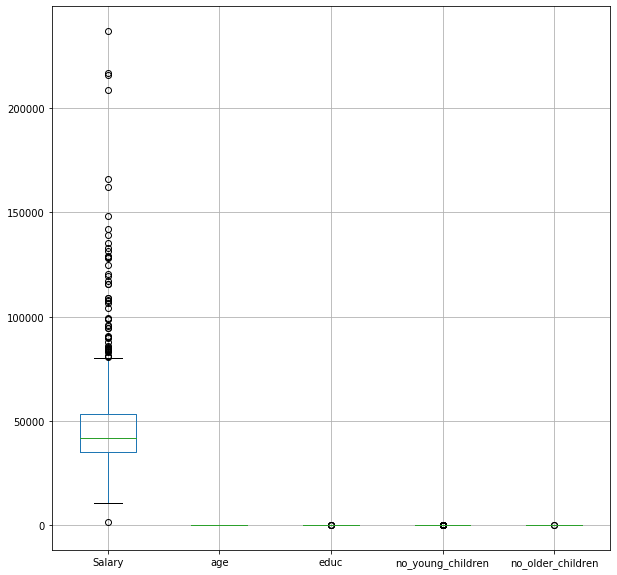

In [93]:
# construct box plot for continuous variables
plt.figure(figsize=(10,10))
holiday.boxplot()

### Treating Outliers

In [94]:
def remove_outlier(col):
    sorted(col)
    Q1,Q3=np.percentile(col,[25,75])
    IQR=Q3-Q1
    lower_range= Q1-(1.5 * IQR)
    upper_range= Q3+(1.5 * IQR)
    return lower_range, upper_range

In [95]:
for column in holiday.columns:
    if holiday[column].dtype != 'object': 
        lr,ur=remove_outlier(holiday[column])
        holiday[column]=np.where(holiday[column]>ur,ur,holiday[column])
        holiday[column]=np.where(holiday[column]<lr,lr,holiday[column])

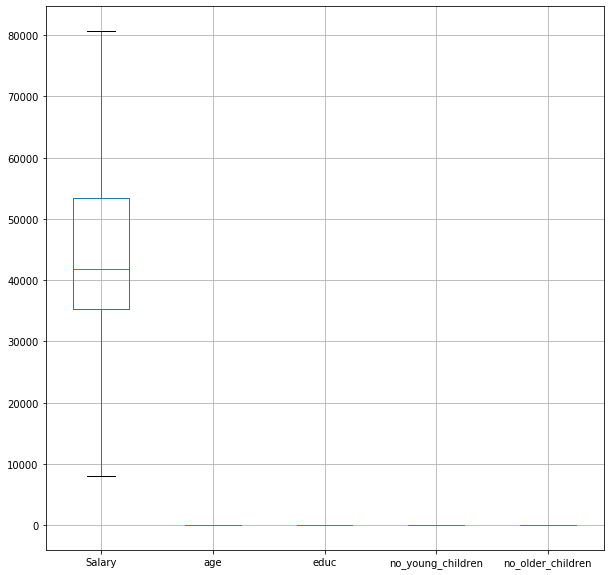

In [96]:
# construct box plot for continuous variables
plt.figure(figsize=(10,10))
holiday.boxplot()

### Checking for Correlations

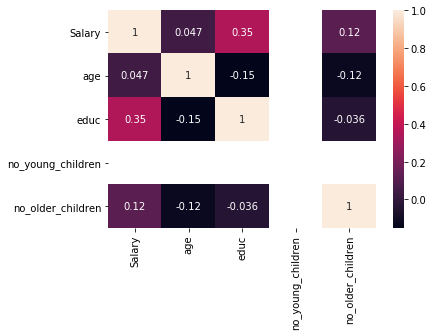

In [97]:
sns.heatmap(holiday.corr(), annot=True)

In [98]:
holiday.describe()

,Salary,age,educ,no_young_children,no_older_children
count,872.000000,872.000000,872.000000,872.0,872.000000
mean,45608.336869,39.955275,9.302752,0.0,0.980505
std,15699.745151,10.551675,3.014712,0.0,1.077197
min,8105.750000,20.000000,2.000000,0.0,0.000000
25%,35324.000000,32.000000,8.000000,0.0,0.000000
50%,41903.500000,39.000000,9.000000,0.0,1.000000
75%,53469.500000,48.000000,12.000000,0.0,2.000000
max,80687.750000,62.000000,18.000000,0.0,5.000000


capital gain and capital loss are both 0 after removing outliers. These 2 variables can be dropped

There is hardly any correlation between the numeric variables

/Users/swathi/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/swathi/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


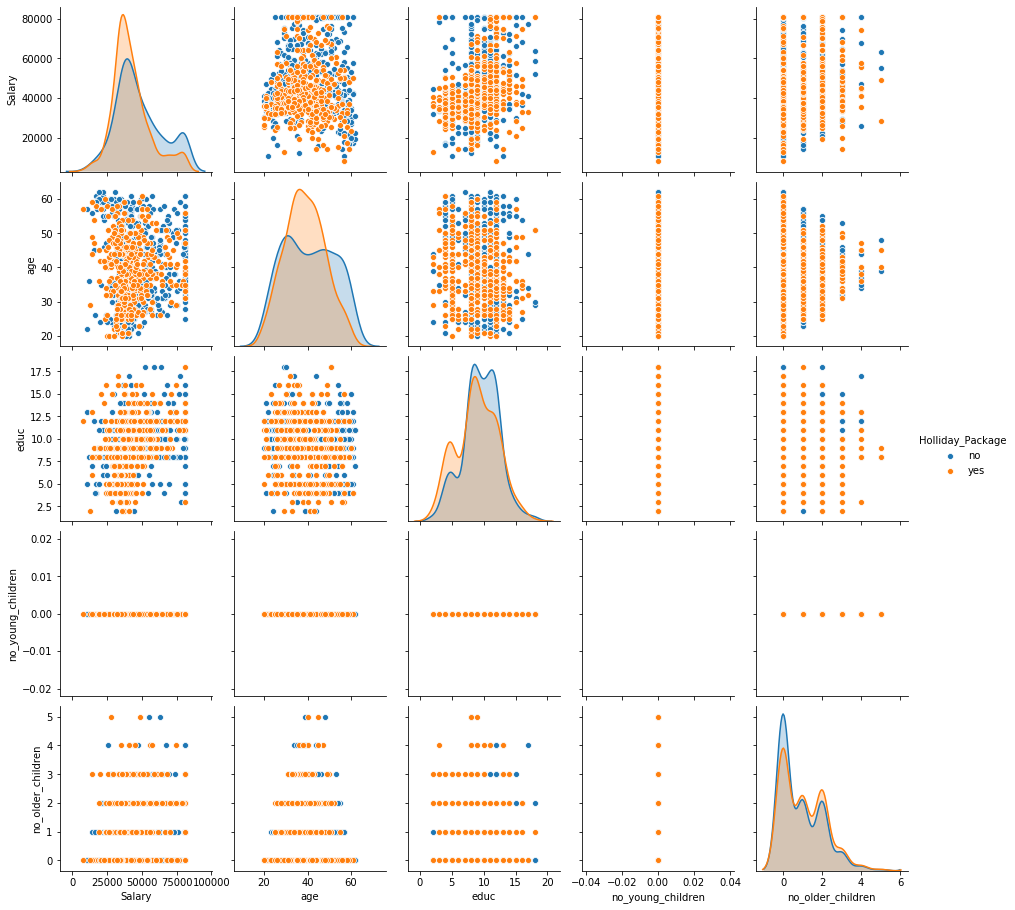

In [99]:
# Pairplot using sns
sns.pairplot(holiday , hue='Holliday_Package' , diag_kind = 'kde')

### Converting all objects to categorical codes

In [100]:
for feature in holiday.columns: 
    if holiday[feature].dtype == 'object': 
        print('\n')
        print('feature:',feature)
        print(pd.Categorical(holiday[feature].unique()))
        print(pd.Categorical(holiday[feature].unique()).codes)
        holiday[feature] = pd.Categorical(holiday[feature]).codes



feature: Holliday_Package
[no, yes]
Categories (2, object): [no, yes]
[0 1]


feature: foreign
[no, yes]
Categories (2, object): [no, yes]
[0 1]


In [101]:
holiday.head()

,Holliday_Package,Salary,age,educ,no_young_children,no_older_children,foreign
0,0,48412.0,30.0,8.0,0.0,1.0,0
1,1,37207.0,45.0,8.0,0.0,1.0,0
2,0,58022.0,46.0,9.0,0.0,0.0,0
3,0,66503.0,31.0,11.0,0.0,0.0,0
4,0,66734.0,44.0,12.0,0.0,2.0,0


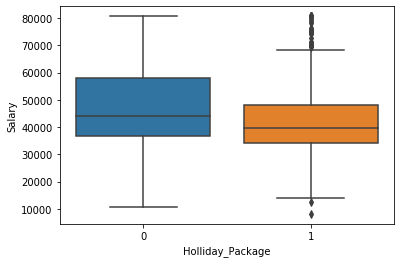

In [102]:
sns.boxplot(holiday["Holliday_Package"],holiday["Salary"])

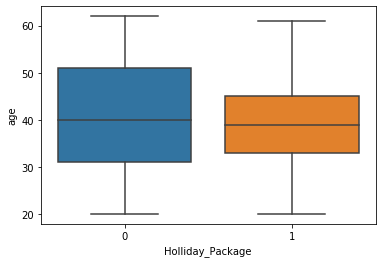

In [103]:
sns.boxplot(holiday["Holliday_Package"],holiday["age"])

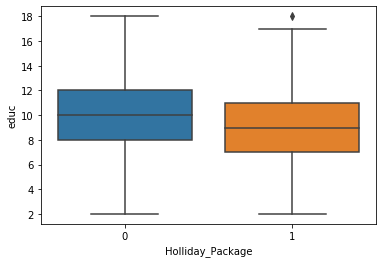

In [104]:
sns.boxplot(holiday["Holliday_Package"],holiday["educ"])

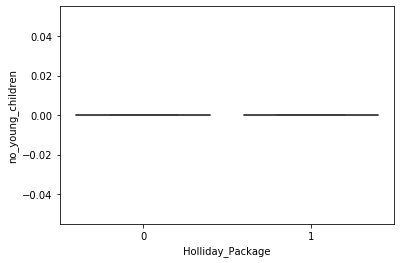

In [105]:
sns.boxplot(holiday["Holliday_Package"],holiday["no_young_children"])

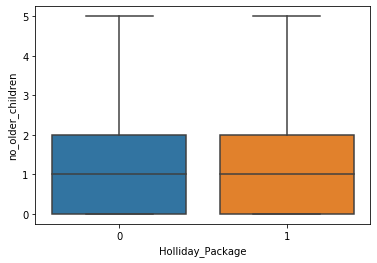

In [106]:
sns.boxplot(holiday["Holliday_Package"],holiday["no_older_children"])

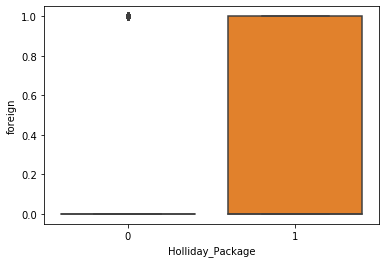

In [107]:
sns.boxplot(holiday["Holliday_Package"],holiday["foreign"])

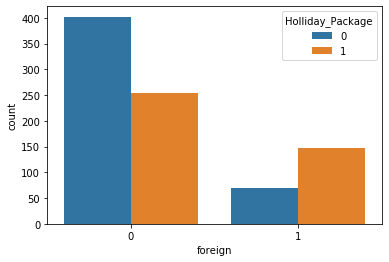

In [108]:
sns.countplot(holiday['foreign'],hue=holiday['Holliday_Package'])

In [109]:
holiday=holiday.drop(columns="no_young_children",axis=1)

In [110]:

holiday=holiday.drop(columns="no_older_children",axis=1)
holiday.head()

,Holliday_Package,Salary,age,educ,foreign
0,0,48412.0,30.0,8.0,0
1,1,37207.0,45.0,8.0,0
2,0,58022.0,46.0,9.0,0
3,0,66503.0,31.0,11.0,0
4,0,66734.0,44.0,12.0,0


### Train Test Split

In [111]:
# Copy all the predictor variables into X dataframe
X = holiday.drop('Holliday_Package', axis=1)

# Copy target into the y dataframe. 
y = holiday['Holliday_Package']

In [112]:
# Split X and y into training and test set in 70:30 ratio
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30 , random_state=1)

### Logistic Regression Model

We are making some adjustments to the parameters in the Logistic Regression Class to get a better accuracy. Details of which can be found out on the site scikit-learn mentioned below

<a href='https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html'>scikit-learn</a>

>Argument=solver{‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, default=’lbfgs’
Algorithm to use in the optimization problem.

>For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones.

>For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss; ‘liblinear’ is limited to one-versus-rest schemes.

>‘newton-cg’, ‘lbfgs’, ‘sag’ and ‘saga’ handle L2 or no penalty

>‘liblinear’ and ‘saga’ also handle L1 penalty

>‘saga’ also supports ‘elasticnet’ penalty

>‘liblinear’ does not support setting penalty='none'

>Note that ‘sag’ and ‘saga’ fast convergence is only guaranteed on features with approximately the same scale. You can preprocess the data with a scaler from sklearn.preprocessing.

>New in version 0.17: Stochastic Average Gradient descent solver.

>New in version 0.19: SAGA solver.

>Changed in version 0.22: The default solver changed from ‘liblinear’ to ‘lbfgs’ in 0.22.

<a href='https://towardsdatascience.com/dont-sweat-the-solver-stuff-aea7cddc3451'> Article on Solvers</a>



In [113]:
# Fit the Logistic Regression model
model = LogisticRegression(solver='newton-cg',max_iter=100000,penalty='none',verbose=True,n_jobs=2)
model.fit(X_train, y_train)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    1.3s finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100000,
                   multi_class='auto', n_jobs=2, penalty='none',
                   random_state=None, solver='newton-cg', tol=0.0001,
                   verbose=True, warm_start=False)

### Predicting on Training and Test dataset

In [114]:
ytrain_predict = model.predict(X_train)
ytest_predict = model.predict(X_test)

### Getting the Predicted Classes and Probs

In [115]:
ytest_predict_prob=model.predict_proba(X_test)
pd.DataFrame(ytest_predict_prob).head()

,0,1
0,0.635953,0.364047
1,0.337011,0.662989
2,0.560320,0.439680
3,0.666044,0.333956
4,0.547276,0.452724


## Model Evaluation

In [116]:
# Accuracy - Training Data
linReg_train_acc=model.score(X_train, y_train)

### AUC and ROC for the training data

AUC: 0.654


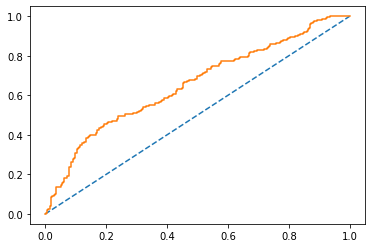

In [117]:
# predict probabilities
probs = model.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(y_train, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr)

In [118]:
# Accuracy - Test Data
model.score(X_test, y_test)

0.6030534351145038

### AUC and ROC for the test data

AUC: 0.654


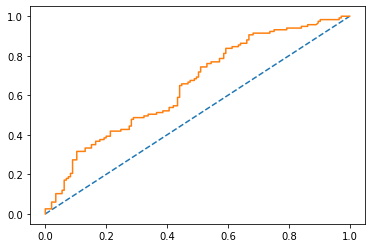

In [119]:
# predict probabilities
probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
test_auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(test_fpr, test_tpr)

### Confusion Matrix for the training data

In [120]:
confusion_matrix(y_train, ytrain_predict)

array([[269,  57],
       [164, 120]])

In [121]:
print(classification_report(y_train, ytrain_predict))
linReg=classification_report(y_train, ytrain_predict,output_dict=True)
df=pd.DataFrame(linReg).transpose()
linReg_train_precision=round(df.loc["1"][1],2)
linReg_train_recall=round(df.loc["1"][2],2)
linReg_train_f1=round(df.loc["1"][0],2)

              precision    recall  f1-score   support

           0       0.62      0.83      0.71       326
           1       0.68      0.42      0.52       284

    accuracy                           0.64       610
   macro avg       0.65      0.62      0.61       610
weighted avg       0.65      0.64      0.62       610



### Confusion Matrix for test data

In [122]:
cnf_matrix=confusion_matrix(y_test, ytest_predict)
cnf_matrix

array([[109,  36],
       [ 68,  49]])

In [123]:
#Test Data Accuracy
linReg_test_acc=model.score(X_test,y_test)
linReg_test_acc

0.6030534351145038

In [124]:
print(classification_report(y_test, ytest_predict))
linReg=classification_report(y_test, ytest_predict,output_dict=True)
df=pd.DataFrame(linReg).transpose()
linReg_test_precision=round(df.loc["1"][1],2)
linReg_test_recall=round(df.loc["1"][2],2)
linReg_test_f1=round(df.loc["1"][0],2)

              precision    recall  f1-score   support

           0       0.62      0.75      0.68       145
           1       0.58      0.42      0.49       117

    accuracy                           0.60       262
   macro avg       0.60      0.59      0.58       262
weighted avg       0.60      0.60      0.59       262



In [125]:
clf=LinearDiscriminantAnalysis()
X= np.asmatrix(X)
model=clf.fit(X,y)
model

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [126]:
pred_class=model.predict(X)

holiday["Prediction"]=pred_class
holiday.head(10)

,Holliday_Package,Salary,age,educ,foreign,Prediction
0,0,48412.00,30.0,8.0,0,0
1,1,37207.00,45.0,8.0,0,0
2,0,58022.00,46.0,9.0,0,0
3,0,66503.00,31.0,11.0,0,0
4,0,66734.00,44.0,12.0,0,0
5,1,61590.00,42.0,12.0,0,0
6,0,80687.75,51.0,8.0,0,0
7,1,35987.00,32.0,8.0,0,0
8,0,41140.00,39.0,12.0,0,0
9,0,35826.00,43.0,11.0,0,0


In [127]:
confusion_matrix(y, pred_class)

array([[390,  81],
       [240, 161]])

In [128]:
lda_test_acc=model.score(X,y)
lda_test_acc

0.6318807339449541

In [129]:
from sklearn.metrics import classification_report
print(classification_report(y, pred_class))
lda=classification_report(y, pred_class,output_dict=True)
df=pd.DataFrame(lda).transpose()
lda_test_precision=round(df.loc["1"][1],2)
lda_test_recall=round(df.loc["1"][2],2)
lda_test_f1=round(df.loc["1"][0],2)

              precision    recall  f1-score   support

           0       0.62      0.83      0.71       471
           1       0.67      0.40      0.50       401

    accuracy                           0.63       872
   macro avg       0.64      0.61      0.60       872
weighted avg       0.64      0.63      0.61       872



In [130]:
model.coef_

array([[-1.87819413e-05, -1.16121415e-02,  2.55018850e-02,
         1.16821113e+00]])

In [131]:
model.intercept_

array([0.61819008])

In [132]:
model.means_

array([[4.82174559e+04, 4.08535032e+01, 9.58386412e+00, 1.46496815e-01],
       [4.25437606e+04, 3.89002494e+01, 8.97256858e+00, 3.66583541e-01]])

In [133]:
index=['Accuracy','Recall','Precision','F1 Score']
data = pd.DataFrame({'Logistic Reg Train':[linReg_train_acc,linReg_train_recall,linReg_train_precision,linReg_train_f1],
        'Logistic Reg Test':[linReg_test_acc,linReg_test_recall,linReg_test_precision,linReg_test_f1],
        'LDA Test':[lda_test_acc,lda_test_recall,lda_test_precision,lda_test_f1]},
                     index=index)

In [134]:
round(data,2)

,Logistic Reg Train,Logistic Reg Test,LDA Test
Accuracy,0.64,0.60,0.63
Recall,0.52,0.49,0.50
Precision,0.42,0.42,0.40
F1 Score,0.68,0.58,0.67


# Conclusion

Accuracy on Test data is 63% and on Train data is 60%.  
AUC is 65% for both.   
Recall and Precision is low and same on both data.  
While the model results between training and test sets are similar, indicating no under or overfitting issues, overall prediction of the model is weaker Considering the class imabalance ratio is moderate and not high, with more training data, the model is expected to perform even better.